In [1]:
# @title Imports

import os
import math
import time
import torch
import nbimporter
import numpy as np

from transformers import AutoTokenizer
from tempfile import TemporaryDirectory
from utils import DEVICE, MAX_TOKEN_LEN
from datasets import load_dataset as load_hf_dataset
from preprocess._utils import smooth_data_preprocess, reshape_calcium_data
from CreateSyntheticDataset import (
    save_synthetic_dataset,
    plot_neural_signals,
    plot_3d_trajectory,
    tokenize_and_chunk,
)

CUDA device found.


## Language modeling with tiny Shakespeare

In [2]:
# @title HuggingFace Tokenizers
# @markdown Note there are two ways to call the tokenizer's encoder.

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
expl_text = "Welcome to the 🤗 Tokenizers library."
impl_text = "We are very happy to show you the 🤗 Transformers library."
expl_encode = tokenizer.encode(expl_text)
impl_encode = tokenizer(impl_text)
print(
    f"Calling `tokenizer.encode(text)`:\n\ttext: {expl_text}\n\ttokenized: {expl_encode}\n\tdecoded: {tokenizer.decode(expl_encode)}",
    end="\n\n",
)
print(
    f"Calling `tokenizer(text)`:\n\tobject.keys(): {impl_encode.keys()}\n\ttext: {impl_text}\n\ttokenized: {impl_encode['input_ids']}\n\tdecoded: {tokenizer.decode(impl_encode['input_ids'])}",
    end="\n\n",
)

Calling `tokenizer.encode(text)`:
	text: Welcome to the 🤗 Tokenizers library.
	tokenized: [101, 6160, 2000, 1996, 100, 19204, 17629, 2015, 3075, 1012, 102]
	decoded: [CLS] welcome to the [UNK] tokenizers library. [SEP]

Calling `tokenizer(text)`:
	object.keys(): dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
	text: We are very happy to show you the 🤗 Transformers library.
	tokenized: [101, 2057, 2024, 2200, 3407, 2000, 2265, 2017, 1996, 100, 19081, 3075, 1012, 102]
	decoded: [CLS] we are very happy to show you the [UNK] transformers library. [SEP]



In [3]:
# @title HuggingFace Datasets

text_dataset = load_hf_dataset("tiny_shakespeare")
print(text_dataset, end="\n\n")
print("~~~" * 50, end="\n\n")

print(
    "train:",
    type(text_dataset["train"]["text"]),
    len(text_dataset["train"]["text"]),
    type(text_dataset["train"]["text"][0]),
    len(text_dataset["train"]["text"][0]),
    end="\n\n",
)
print(
    "validation:",
    type(text_dataset["validation"]["text"]),
    len(text_dataset["validation"]["text"]),
    type(text_dataset["validation"]["text"][0]),
    len(text_dataset["validation"]["text"][0]),
    end="\n\n",
)
print(
    "test:",
    type(text_dataset["test"]["text"]),
    len(text_dataset["test"]["text"]),
    type(text_dataset["test"]["text"][0]),
    len(text_dataset["test"]["text"][0]),
    end="\n\n",
)

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 1
    })
    validation: Dataset({
        features: ['text'],
        num_rows: 1
    })
    test: Dataset({
        features: ['text'],
        num_rows: 1
    })
})

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

train: <class 'list'> 1 <class 'str'> 1003854

validation: <class 'list'> 1 <class 'str'> 55770

test: <class 'list'> 1 <class 'str'> 55770



In [ ]:
# @title Tokenization and Chunking
# @markdown Apply the tokenization and chunking to each split.

text_dataset = text_dataset.map(
    tokenize_and_chunk, batched=True, fn_kwargs=dict(tokenizer=tokenizer)
)
print(text_dataset, end="\n\n")
print("~~~" * 50, end="\n\n")

print(
    "text_dataset['train']['input_ids']:\n",
    "\ttype:",
    type(text_dataset["train"]["input_ids"]),
    "\n\tlength:",
    len(text_dataset["train"]["input_ids"]),
    end="\n\n",
)
print(
    "text_dataset['train']['input_ids'][0]:\n",
    "\ttype:",
    type(text_dataset["train"]["input_ids"][0]),
    "\n\tlength:",
    len(text_dataset["train"]["input_ids"][0]),
    end="\n\n",
)
print(
    "text_dataset['train']['input_ids'][0][0]:\n",
    "\ttype:",
    type(text_dataset["train"]["input_ids"][0][0]),
    "\n\tvalue:",
    text_dataset["train"]["input_ids"][0][0],
    end="\n\n",
)
print("~~~" * 50, end="\n\n")

print(f"Original sequence (text):\n\t{text_dataset['train']['text'][0]}", end="\n\n")
print(
    f"Encoded sequence (tokens):\n\t {text_dataset['train']['input_ids'][0]}",
    end="\n\n",
)
print(
    f"Decoded sequence (tokens):\n\t {tokenizer.decode(text_dataset['train']['input_ids'][0])}",
    end="\n\n",
)

In [ ]:
# @title Define the Transformer model


class PositionalEncoding(torch.nn.Module):
    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 1000):
        super().__init__()
        self.dropout = torch.nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model)
        )
        pe = torch.zeros(1, max_len, d_model)  # batch_first=True
        pe[0, :, 0::2] = torch.sin(position * div_term)
        pe[0, :, 1::2] = torch.cos(position * div_term)
        self.register_buffer("pe", pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Arguments:
            x: Tensor, shape ``[batch_size, seq_len, embedding_dim]``
        """
        x = x + self.pe[:, : x.size(1), :]
        return self.dropout(x)


class TransformerModel(torch.nn.Module):
    def __init__(
        self,
        ntoken: int,
        d_model: int,
        nhead: int,
        d_hid: int,
        nlayers: int,
        dropout: float = 0.5,
    ):
        super().__init__()
        self.model_type = "Transformer"
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layers = torch.nn.TransformerEncoderLayer(
            d_model, nhead, d_hid, dropout, batch_first=True
        )
        self.transformer_encoder = torch.nn.TransformerEncoder(encoder_layers, nlayers)
        self.embedding = torch.nn.Embedding(ntoken, d_model)
        self.d_model = d_model
        self.linear = torch.nn.Linear(d_model, ntoken)

        self.init_weights()

    def init_weights(self) -> None:
        initrange = 0.1
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.linear.bias.data.zero_()
        self.linear.weight.data.uniform_(-initrange, initrange)

    def forward(self, src: torch.Tensor, src_mask: torch.Tensor = None) -> torch.Tensor:
        """
        Arguments:
            src: Tensor, shape [batch_size, seq_len]
            src_mask: Tensor, shape [seq_len, seq_len]

        Returns:
            output Tensor of shape [batch_size, seq_len, ntoken]
        """
        src = self.embedding(src) * math.sqrt(self.d_model)
        src = self.pos_encoder(src)
        if src_mask is None:
            src_mask = torch.nn.Transformer.generate_square_subsequent_mask(
                src.size(1)  # Use src.size(1) to get the seq_len
            ).to(
                src.device
            )  # Use src.device to match device of src
        output = self.transformer_encoder(src, src_mask)
        output = self.linear(output)
        return output

    @torch.no_grad()
    def generate(
        self,
        idx: torch.LongTensor,
        max_new_tokens: int,
        temperature=1.0,
        top_k=None,
    ):
        """
        Special generate method for the Transformer model.
        Take a conditioning sequence of indices idx (LongTensor of shape (b,t)) and complete
        the sequence max_new_tokens times, feeding the predictions back into the model each time.
        Since we trained the model to directly predict the next token we take the index as the argmin
        over the distance between the output and the embedding table.
        """
        # Set model to evaluation mode
        self.eval()

        # Loop through time
        for _ in range(max_new_tokens):
            # if the sequence context is growing too long we must crop it at block_size
            idx_cond = idx if idx.size(1) <= MAX_TOKEN_LEN else idx[:, -MAX_TOKEN_LEN:]
            # forward the model to get the output
            outputs = self(idx_cond)
            # pluck the logits at the final step and scale by desired temperature
            logits = outputs[:, -1, :] / temperature
            # optionally crop the logits to only the top k options
            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = -float("Inf")
            # apply softmax to convert logits to (normalized) probabilities
            probs = torch.nn.functional.softmax(logits, dim=-1)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1).view(1, 1)
            # append sampled index to the running sequence and continue
            idx = torch.cat((idx, idx_next), dim=1)

        return idx

In [ ]:
# @title Initiate an instance

ntokens = tokenizer.vocab_size
emsize = 302  # embedding dimension
d_hid = 302  # dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 1  # number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 2  # number of heads in nn.MultiheadAttention (NOTE: nhead must be a divisor of d_hid)
dropout = 0.1  # dropout probability
model = TransformerModel(ntokens, emsize, nhead, d_hid, nlayers, dropout).to(DEVICE)

In [ ]:
# @title Train the Transformer model

criterion = torch.nn.CrossEntropyLoss()
lr = 1.0  # 5.0 # learning rate
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)


def train(model: torch.nn.Module) -> None:
    model.train()  # turn on train mode
    total_loss = 0.0
    log_interval = 300
    start_time = time.time()
    global epoch

    num_batches = len(text_dataset["train"]["input_ids"])
    for batch in range(num_batches):
        tokens = text_dataset["train"]["input_ids"][batch]
        # parse into input and target
        input = (
            torch.LongTensor(tokens[:-1]).unsqueeze(0).to(DEVICE)
        )  # ``[batch_size=1, seq_len]``
        target = (
            torch.LongTensor(tokens[1:]).unsqueeze(0).reshape(-1).to(DEVICE)
        )  # ``[batch_size=1 * seq_len]``
        # forward pass
        output = model(input)  # ``[batch_size=1, seq_len, ntokens]``
        output_flat = output.view(-1, ntokens)  # ``[batch_size=1 * seq_len, ntokens]``
        # backpropagation step
        optimizer.zero_grad()
        loss = criterion(output_flat, target)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

        total_loss += loss.item()
        if batch % log_interval == 0 and batch > 0:
            lr = scheduler.get_last_lr()[0]
            ms_per_batch = (time.time() - start_time) * 1000 / log_interval
            cur_loss = total_loss / log_interval
            ppl = math.exp(cur_loss)
            print(
                f"| epoch {epoch:3d} | {batch:5d}/{num_batches:5d} batches | "
                f"lr {lr:02.2f} | ms/batch {ms_per_batch:5.2f} | "
                f"loss {cur_loss:5.2f} | ppl {ppl:8.2f}"
            )
            total_loss = 0
            start_time = time.time()


def evaluate(model: torch.nn.Module) -> float:
    model.eval()  # turn on evaluation mode
    total_loss = 0.0
    with torch.no_grad():
        num_batches = len(text_dataset["validation"]["input_ids"])
        for batch in range(num_batches):
            tokens = text_dataset["validation"]["input_ids"][batch]
            input = torch.LongTensor(tokens[:-1]).unsqueeze(0).to(DEVICE)
            target = torch.LongTensor(tokens[1:]).unsqueeze(0).reshape(-1).to(DEVICE)
            seq_len = input.size(1)
            output = model(input)
            output_flat = output.view(-1, ntokens)
            total_loss += criterion(output_flat, target).item()
    return total_loss / num_batches

In [ ]:
# @markdown Loop over epochs. Save the model if the validation loss is the best we’ve seen so far. Adjust the learning rate after each epoch.

best_val_loss = float("inf")
epochs = 1

final_model_params_path = os.path.join("../models/", "shakespeare_transformer_model.pt")
if os.path.exists(final_model_params_path):
    print("Loading a previously saved model checkpoint...")
    model.load_state_dict(torch.load(final_model_params_path))

with TemporaryDirectory() as tempdir:
    best_model_params_path = os.path.join(tempdir, "best_model_params.pt")

    for epoch in range(1, epochs + 1):
        epoch_start_time = time.time()
        train(model)
        val_loss = evaluate(model)
        val_ppl = math.exp(val_loss)
        elapsed = time.time() - epoch_start_time
        print("-" * 89)
        print(
            f"| end of epoch {epoch:3d} | time: {elapsed:5.2f}s | "
            f"valid loss {val_loss:5.2f} | valid ppl {val_ppl:8.2f}"
        )
        print("-" * 89)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), best_model_params_path)

        scheduler.step()

    print(f"Loading and saving the new best model...")
    model.load_state_dict(torch.load(best_model_params_path))  # load best model states
    torch.save(
        model.state_dict(),
        os.path.join("../models/", "shakespeare_transformer_model.pt"),
    )  # save the best model for later use

In [ ]:
# @title Generate new text using test input

max_new_tokens = 100
idx = torch.LongTensor(text_dataset["test"]["input_ids"][0]).unsqueeze(0).to(DEVICE)
idx_gen = model.generate(idx, max_new_tokens, top_k=5)

print(idx.shape, idx_gen.shape, end="\n\n")
print(tokenizer.decode(idx.tolist()[0]), end="\n\n")
print(tokenizer.decode(idx_gen.tolist()[0][-max_new_tokens:]), end="\n\n")

## Neural data modeling

In [2]:
# @title Get a neural dataset

import random
from data._utils import pick_worm
from data._utils import load_dataset as load_neural_dataset

# a synthetic dataset where the neural activity is the embeddings of tokens from the tiny_shakespeare
Shakespeare0000 = load_neural_dataset("Shakespeare0000")
neural_dataset = pick_worm(Shakespeare0000, 0)

data = neural_dataset["calcium_data"].unsqueeze(0)
print("data: ", data.shape, data.dtype, data.requires_grad, data.device, end="\n\n")

mask = neural_dataset["named_neurons_mask"].unsqueeze(0)
print("mask:", mask.shape, mask.dtype, mask.requires_grad, mask.device, end="\n\n")

# Get the keys from the dictionary
keys = list(Shakespeare0000.keys())

# Randomly sample half the keys without replacement
half_keys = random.sample(keys, len(keys) // 2)

# Create two new dictionaries using the sampled keys
train_Shakespeare0000 = {k: Shakespeare0000[k] for k in half_keys}
validation_Shakespeare0000 = {k: Shakespeare0000[k] for k in keys if k not in half_keys}

# Print the two dictionaries
print("Dictionary 1:")
print(len(train_Shakespeare0000.keys()), end="\n\n")
print("\nDictionary 2:")
print(len(validation_Shakespeare0000.keys()), end="\n\n")

data:  torch.Size([1, 3000, 302]) torch.float16 False cpu

mask: torch.Size([1, 302]) torch.bool False cpu

Dictionary 1:
100


Dictionary 2:
100



In [3]:
# @title Create a NeuralTransformer model

from models._utils import NeuralTransformer

model = NeuralTransformer(input_size=302, hidden_size=512).to(DEVICE)

# test input-output functionality
mask = mask.to(DEVICE)
input = data[:, :-1, :].to(DEVICE)
target = data[:, 1:, :].to(DEVICE)
output = model(input, mask)

print("input:", input.shape, input.dtype, input.requires_grad, input.device, end="\n\n")
print(
    "target:",
    target.shape,
    target.dtype,
    target.requires_grad,
    target.device,
    end="\n\n",
)
print(
    "output:",
    output.shape,
    output.dtype,
    output.requires_grad,
    output.device,
    end="\n\n",
)

# test optimization and computation graph
lr = 5.0  # learning rate
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)
optimizer.zero_grad()
loss = model.loss_fn()(output, target)
loss.backward()
optimizer.step()
print(f"Loss: {loss.item():.3f}")

input: torch.Size([1, 2999, 302]) torch.float16 False cuda:0

target: torch.Size([1, 2999, 302]) torch.float16 False cuda:0

output: torch.Size([1, 2999, 1024]) torch.float16 True cuda:0

Loss: 30.922


In [4]:
# @title Train the NeuralTransformer model

model = NeuralTransformer(input_size=302, hidden_size=512).to(DEVICE)
lr = 5.0  # 1.0 # learning rate
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)


def train(model: torch.nn.Module) -> None:
    model.train()  # turn on train mode
    total_loss = 0.0
    log_interval = 10
    start_time = time.time()
    global epoch

    num_batches = len(train_Shakespeare0000)
    gen = iter(train_Shakespeare0000)
    for batch in range(num_batches):
        neural_dataset = pick_worm(train_Shakespeare0000, next(gen))
        data = neural_dataset["calcium_data"].unsqueeze(0)
        mask = neural_dataset["named_neurons_mask"].unsqueeze(0)
        # parse into input and target
        mask = mask.to(DEVICE)
        input = data[:, :-1, :].to(DEVICE)
        target = data[:, 1:, :].to(DEVICE)
        # forward pass
        output = model(input, mask)  # ``[batch_size=1, seq_len, ntokens]``
        # backpropopagation step
        optimizer.zero_grad()
        loss = model.loss_fn()(
            output, target
        )  # flatens output to ``[batch_size=1 * seq_len, ntokens]``
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

        total_loss += loss.item()
        if batch % log_interval == 0 and batch > 0:
            lr = scheduler.get_last_lr()[0]
            ms_per_batch = (time.time() - start_time) * 1000 / log_interval
            cur_loss = total_loss / log_interval
            ppl = math.exp(cur_loss)
            print(
                f"| epoch {epoch:3d} | {batch:5d}/{num_batches:5d} batches | "
                f"lr {lr:02.2f} | ms/batch {ms_per_batch:5.2f} | "
                f"loss {cur_loss:5.2f} | ppl {ppl:8.2f}"
            )
            total_loss = 0
            start_time = time.time()


def evaluate(model: torch.nn.Module) -> float:
    model.eval()  # turn on evaluation mode
    total_loss = 0.0
    with torch.no_grad():
        num_batches = len(validation_Shakespeare0000)
        gen = iter(validation_Shakespeare0000)
        for batch in range(num_batches):
            neural_dataset = pick_worm(validation_Shakespeare0000, next(gen))
            data = neural_dataset["calcium_data"].unsqueeze(0)
            mask = neural_dataset["named_neurons_mask"].unsqueeze(0)
            mask = mask.to(DEVICE)
            input = data[:, :-1, :].to(DEVICE)
            target = data[:, 1:, :].to(DEVICE)
            output = model(input, mask)
            loss = model.loss_fn()(output, target)
            total_loss += loss.item()
    return total_loss / num_batches

In [5]:
# @markdown Loop over epochs. Save the model if the validation loss is the best we’ve seen so far. Adjust the learning rate after each epoch.

best_val_loss = float("inf")
epochs = 20

final_model_params_path = os.path.join("../models/", "neural_transformer_model.pt")
if os.path.exists(final_model_params_path):
    print("Loading a previously saved model checkpoint...")
    model.load_state_dict(torch.load(final_model_params_path))

with TemporaryDirectory() as tempdir:
    best_model_params_path = os.path.join(tempdir, "best_model_params.pt")

    for epoch in range(1, epochs + 1):
        epoch_start_time = time.time()
        train(model)
        val_loss = evaluate(model)
        val_ppl = math.exp(val_loss)
        elapsed = time.time() - epoch_start_time
        print("-" * 89)
        print(
            f"| end of epoch {epoch:3d} | time: {elapsed:5.2f}s | "
            f"valid loss {val_loss:5.2f} | valid ppl {val_ppl:8.2f}"
        )
        print("-" * 89)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), best_model_params_path)

        scheduler.step()

    print(f"Loading and saving the new best model...")
    model.load_state_dict(torch.load(best_model_params_path))  # load best model states
    torch.save(
        model.state_dict(),
        os.path.join("../models/", "neural_transformer_model.pt"),
    )  # save the best model for later use

| epoch   1 |    10/  100 batches | lr 5.00 | ms/batch 31.58 | loss 117.90 | ppl 1602051919510640008154071466837369019025317540397056.00
| epoch   1 |    20/  100 batches | lr 5.00 | ms/batch 26.22 | loss 84.67 | ppl 5904333968710534549943895877155291136.00
| epoch   1 |    30/  100 batches | lr 5.00 | ms/batch 25.65 | loss 57.25 | ppl 7323459079081677318782976.00
| epoch   1 |    40/  100 batches | lr 5.00 | ms/batch 26.66 | loss 44.97 | ppl 33753810886753910784.00
| epoch   1 |    50/  100 batches | lr 5.00 | ms/batch 24.82 | loss 38.43 | ppl 49185487235151568.00
| epoch   1 |    60/  100 batches | lr 5.00 | ms/batch 24.55 | loss 36.13 | ppl 4915893881348630.00
| epoch   1 |    70/  100 batches | lr 5.00 | ms/batch 24.43 | loss 33.96 | ppl 558485627501420.00
| epoch   1 |    80/  100 batches | lr 5.00 | ms/batch 24.37 | loss 38.41 | ppl 47971093228386088.00
| epoch   1 |    90/  100 batches | lr 5.00 | ms/batch 24.44 | loss 31.65 | ppl 55818417858292.26
------------------------------

In [6]:
# @title Generate new data using test input

max_new_tokens = 100
input_gen = model.transformer_generate(input, mask, max_new_tokens)

print(input.shape, input_gen.shape, end="\n\n")

logits: torch.Size([1, 1024])
token_next: 6
logits: torch.Size([1, 1024])
token_next: 6
logits: torch.Size([1, 1024])
token_next: 6
logits: torch.Size([1, 1024])
token_next: 6
logits: torch.Size([1, 1024])
token_next: 6
logits: torch.Size([1, 1024])
token_next: 142
logits: torch.Size([1, 1024])
token_next: 601
logits: torch.Size([1, 1024])
token_next: 601
logits: torch.Size([1, 1024])
token_next: 779
logits: torch.Size([1, 1024])
token_next: 779
logits: torch.Size([1, 1024])
token_next: 779
logits: torch.Size([1, 1024])
token_next: 779
logits: torch.Size([1, 1024])
token_next: 779
logits: torch.Size([1, 1024])
token_next: 779
logits: torch.Size([1, 1024])
token_next: 779
logits: torch.Size([1, 1024])
token_next: 779
logits: torch.Size([1, 1024])
token_next: 779
logits: torch.Size([1, 1024])
token_next: 779
logits: torch.Size([1, 1024])
token_next: 779
logits: torch.Size([1, 1024])
token_next: 779
logits: torch.Size([1, 1024])
token_next: 779


logits: torch.Size([1, 1024])
token_next: 779
logits: torch.Size([1, 1024])
token_next: 779
logits: torch.Size([1, 1024])
token_next: 779
logits: torch.Size([1, 1024])
token_next: 779
logits: torch.Size([1, 1024])
token_next: 779
logits: torch.Size([1, 1024])
token_next: 779
logits: torch.Size([1, 1024])
token_next: 779
logits: torch.Size([1, 1024])
token_next: 779
logits: torch.Size([1, 1024])
token_next: 779
logits: torch.Size([1, 1024])
token_next: 779
logits: torch.Size([1, 1024])
token_next: 529
logits: torch.Size([1, 1024])
token_next: 529
logits: torch.Size([1, 1024])
token_next: 6
logits: torch.Size([1, 1024])
token_next: 6
logits: torch.Size([1, 1024])
token_next: 956
logits: torch.Size([1, 1024])
token_next: 587
logits: torch.Size([1, 1024])
token_next: 587
logits: torch.Size([1, 1024])
token_next: 587
logits: torch.Size([1, 1024])
token_next: 587
logits: torch.Size([1, 1024])
token_next: 587
logits: torch.Size([1, 1024])
token_next: 587
logits: torch.Size([1, 1024])
token_ne

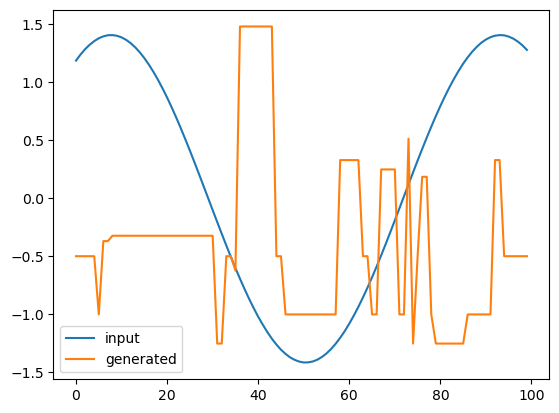

In [7]:
import matplotlib.pyplot as plt

plt.plot(input[0, -max_new_tokens:, mask.squeeze()][:, 0].cpu().numpy(), label="input")
plt.plot(
    input_gen[0, -max_new_tokens:, mask.squeeze()][:, 0].cpu().numpy(),
    label="generated",
)
plt.legend()